In [60]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN

In [61]:
#the excelbook had two sheets so I had to save them individually
df1 = pd.read_csv('online_retail_2010-2011.csv')
df2 = pd.read_csv('online_retail_2009-2010.csv')

In [62]:
#combine both years
data = pd.concat([df1, df2], ignore_index=True)

In [63]:
#delete duplicate rows
data = data.drop_duplicates()

#sometimes quantity and price are weird
df = df[(df["Quantity"] >= 0) & (df["Price"] > 0)]

NameError: name 'df' is not defined

In [ ]:
#check to see if deleting rows with missing data is viable

initial_row_count = len(data)
print(f"Initial number of rows: {initial_row_count}")

# Drop rows with any missing data
data_cleaned = data.dropna()


final_row_count = len(data_cleaned)
print(f"Number of rows after removing rows with empty data: {final_row_count}")

In [ ]:
missing_counts = data.isnull().sum()
missing_percentages = (missing_counts / len(data)) * 100
missing_summary = pd.DataFrame({
    'Missing Values': missing_counts,
    'Percentage (%)': missing_percentages
})
missing_summary_sorted = missing_summary.sort_values(by='Missing Values', ascending=False)
print(missing_summary_sorted)

In [ ]:
#The VAST majority of the missing data is in the customer ID column. This means it is probably best to have two dataframes. One with cleanedrows for where customer ID is crucial and one without where customer ID doesn't matter

In [ ]:
#Since none of the following graphs involve Costumer ID at all we can rely on the larger dataset.
data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'], format='%m/%d/%Y %H:%M')
print(data['InvoiceDate'].head())

In [ ]:
data['Hour'] = data['InvoiceDate'].dt.hour
data['DayOfWeek'] = data['InvoiceDate'].dt.day_name()
data['Month'] = data['InvoiceDate'].dt.month

data['Revenue'] = data['Quantity'] * data['Price']

In [ ]:
time_of_day_revenue = data.groupby('Hour')['Revenue'].sum()
plt.figure(figsize=(10, 6))
plt.plot(time_of_day_revenue.index, time_of_day_revenue.values, marker='o', linestyle='-', linewidth=2)
plt.title('Revenue by Time of Day', fontsize=16)
plt.xlabel('Hour of Day (24-hour format)', fontsize=14)
plt.ylabel('Total Revenue', fontsize=14)
plt.xticks(range(0, 24))
plt.grid(True)
plt.show()

In [ ]:
time_of_day_revenue = data.groupby('Hour')['Quantity'].sum()
plt.figure(figsize=(10, 6))
plt.plot(time_of_day_revenue.index, time_of_day_revenue.values, marker='o', linestyle='-', linewidth=2)
plt.title('Quantity by Time of Day', fontsize=16)
plt.xlabel('Hour of Day (24-hour format)', fontsize=14)
plt.ylabel('Total Revenue', fontsize=14)
plt.xticks(range(0, 24))
plt.grid(True)
plt.show()

In [ ]:
#These results clearly show us that quantity of items bought and revenue to the store are fairly linked. This also shows us that the amount of both have a bell-esque curve peaking at noon.
#Interestingly, this data also shows us the opening and closing times of the store. Namely 6 am and closing at 9 pm. This is strange as the data is said to come from an online store

In [ ]:
data['DayOfWeek'].value_counts().plot(kind='bar', title='Transactions by Day of Week')
plt.show()

In [ ]:
#It seems as though people like to buy earlier in the week. Strangly there is no data on Saturday despite the data coming from an online store.

In [64]:
data.groupby('Month')['Revenue'].sum().plot(kind='line', title='Monthly Revenue Trend')
plt.show()

KeyError: 'Month'

In [ ]:
#as could be predicted the amount of purchases heavily spikes around holiday time. You can clearly see a massive spike in November. This could possibly be black friday sales.

In [ ]:
data.groupby('Country')['Revenue'].sum().sort_values(ascending=False).head(10).plot(kind='bar', title='Revenue by Country')
plt.show()

In [ ]:
#also to be expected is the dominance of UK sales. This makes sense as the company is based within the United Kingdom

In [ ]:
#TASK 2: Customer Segentation

In [ ]:
print(data_cleaned.columns)

In [ ]:
data_cleaned = data.dropna()

# Group data by 'CustomerID' and aggregate purchase data. Since this requires customer ID we must use the Data cleaned data frame.
customer_data = data_cleaned.groupby('Customer ID').agg(
    total_revenue=('Revenue', 'sum'),
    purchase_count=('Invoice', 'nunique'),  # Use 'Invoice' instead of 'InvoiceNo'
    avg_transaction_size=('Revenue', 'mean'),
    last_purchase_date=('InvoiceDate', 'max'),
    product_diversity=('StockCode', 'nunique')
)

# Create recency feature (days since last purchase)
customer_data['recency'] = (data_cleaned['InvoiceDate'].max() - customer_data['last_purchase_date']).dt.days
customer_data = customer_data.drop(columns=['last_purchase_date'])  # Drop the date column as we now have recency


In [ ]:
features = ['total_revenue', 'purchase_count', 'avg_transaction_size', 'recency', 'product_diversity']

scaler = StandardScaler()
customer_data_scaled = scaler.fit_transform(customer_data[features])

customer_data_scaled = pd.DataFrame(customer_data_scaled, columns=features, index=customer_data.index)

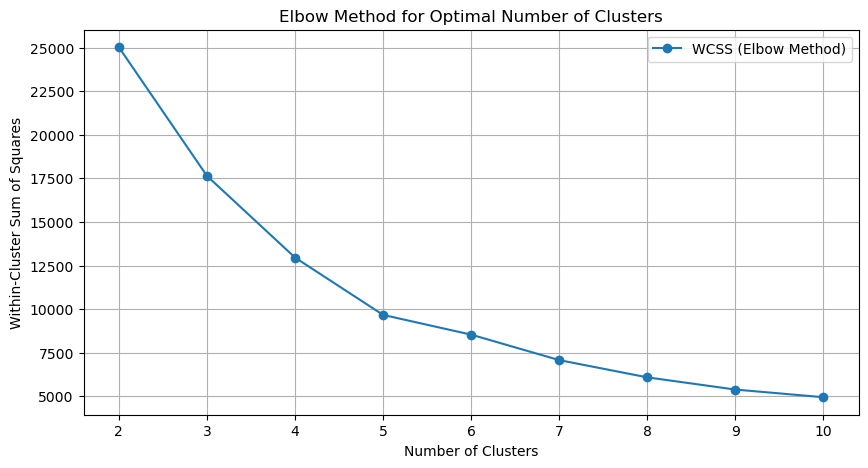

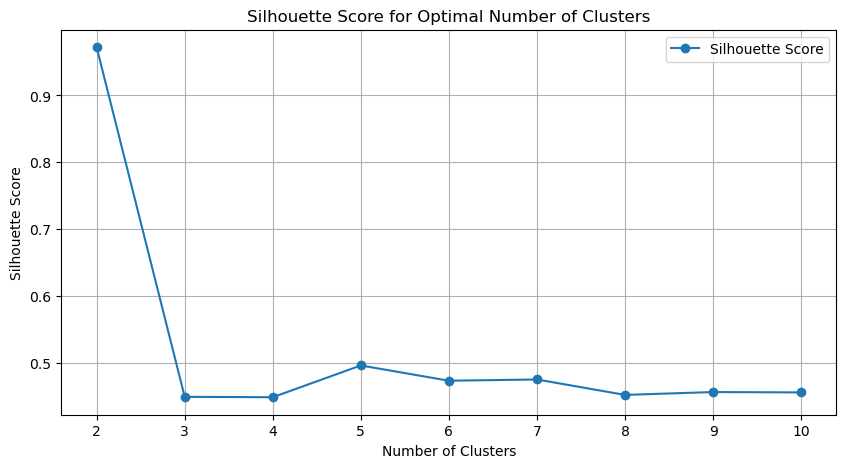

In [65]:
from sklearn.metrics import silhouette_score

range_n_clusters = range(2, 11)
wcss = []  # Within-Cluster Sum of Squares for the Elbow Method
silhouette_scores = []  # Silhouette scores for each cluster count

for n_clusters in range_n_clusters:
    # Perform KMeans clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(customer_data_scaled)
    
    # Append WCSS
    wcss.append(kmeans.inertia_)
    
    # Calculate the silhouette score and append it
    cluster_labels = kmeans.labels_
    silhouette_avg = silhouette_score(customer_data_scaled, cluster_labels)
    silhouette_scores.append(silhouette_avg)

# Plot Elbow Method
plt.figure(figsize=(10, 5))
plt.plot(range_n_clusters, wcss, marker='o', label='WCSS (Elbow Method)')
plt.xlabel('Number of Clusters')
plt.ylabel('Within-Cluster Sum of Squares')
plt.title('Elbow Method for Optimal Number of Clusters')
plt.grid()
plt.legend()
plt.show()

# Plot Silhouette Score
plt.figure(figsize=(10, 5))
plt.plot(range_n_clusters, silhouette_scores, marker='o', label='Silhouette Score')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for Optimal Number of Clusters')
plt.grid()
plt.legend()
plt.show()

In [66]:
#This data suggests that 5 clusters is pretty good

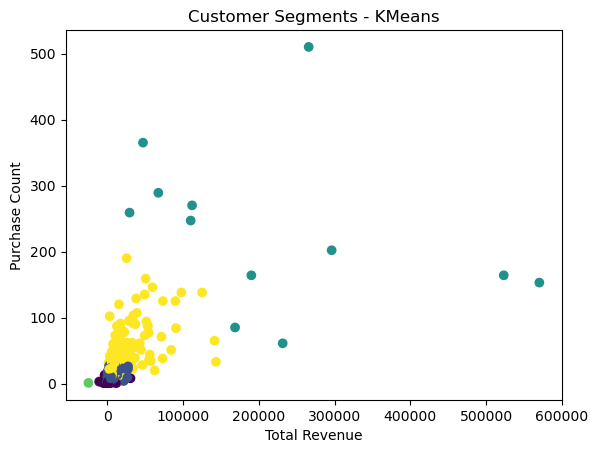

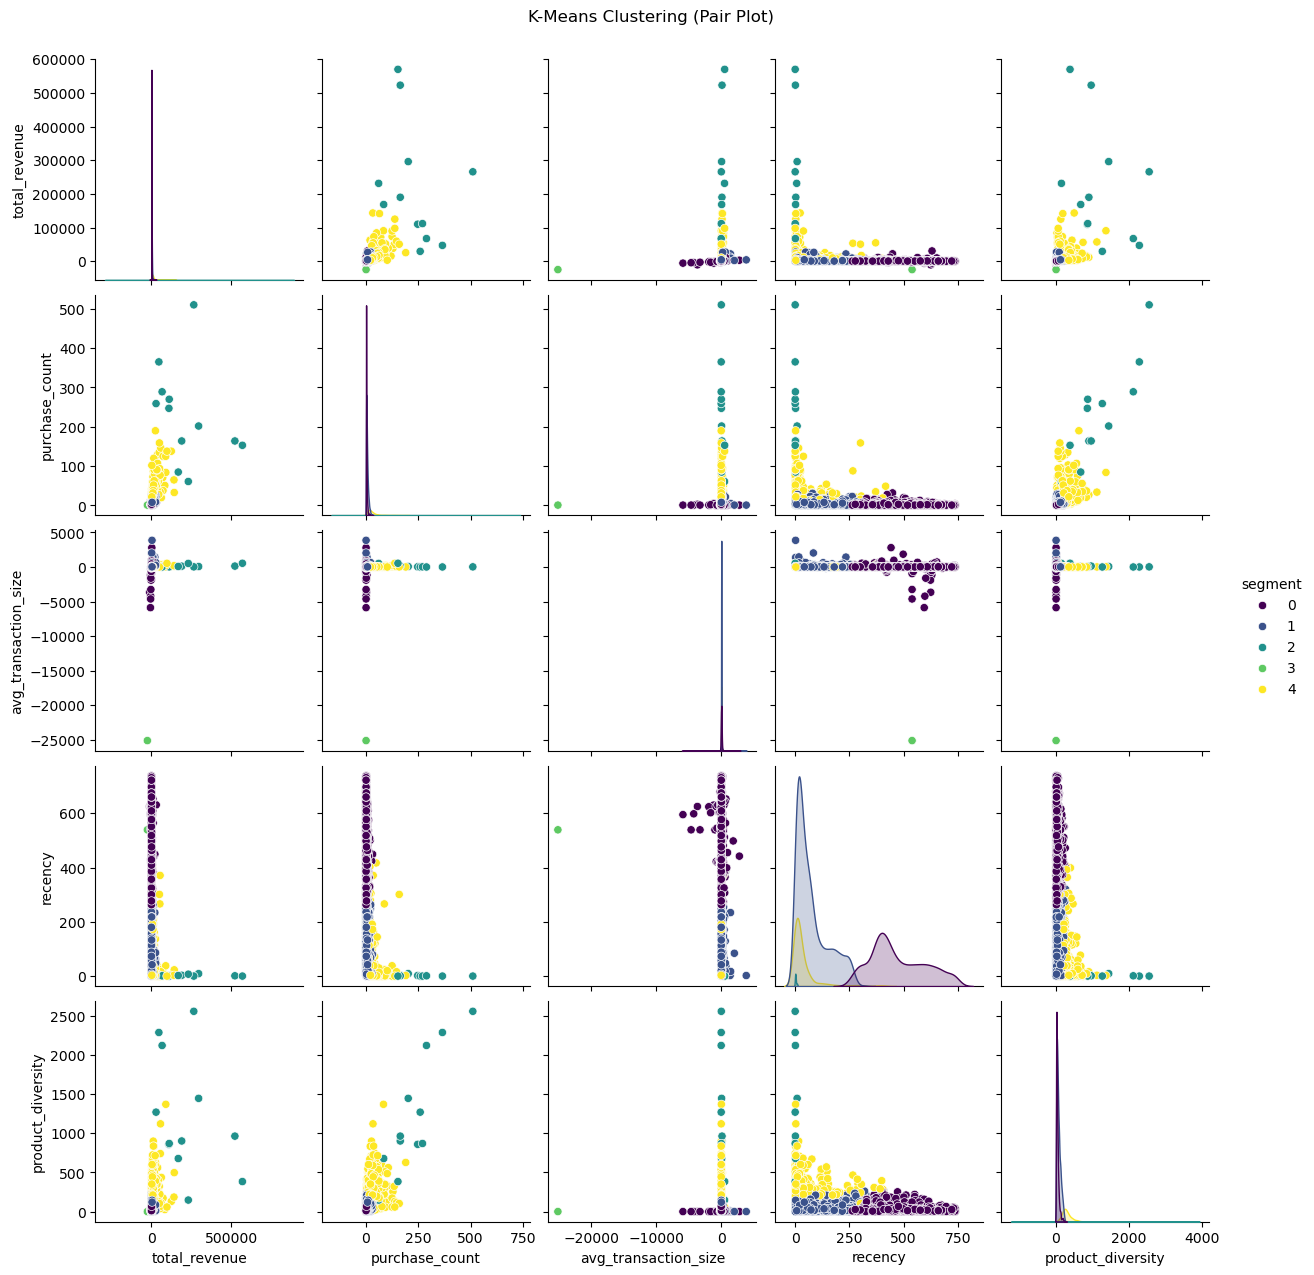

In [67]:
kmeans = KMeans(n_clusters=5, random_state=42)
customer_data['segment'] = kmeans.fit_predict(customer_data_scaled)

plt.scatter(customer_data['total_revenue'], customer_data['purchase_count'], c=customer_data['segment'], cmap='viridis')
plt.xlabel('Total Revenue')
plt.ylabel('Purchase Count')
plt.title('Customer Segments - KMeans')
plt.show()

sns.pairplot(customer_data, vars=features, hue='segment', palette='viridis')
plt.suptitle('K-Means Clustering (Pair Plot)', y=1.02)
plt.show()

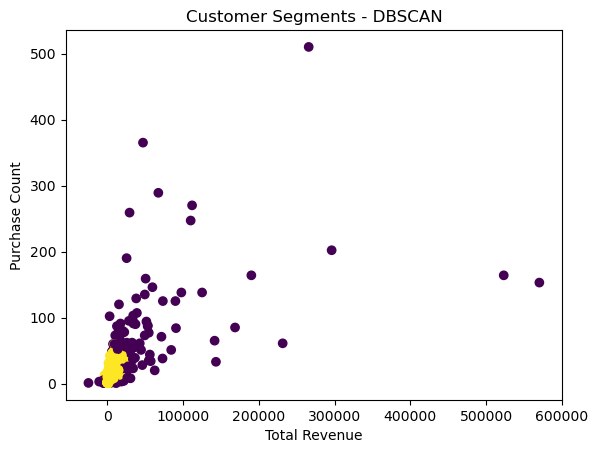

In [68]:
from sklearn.cluster import DBSCAN

dbscan = DBSCAN(eps=0.5, min_samples=5)
customer_data['segment'] = dbscan.fit_predict(customer_data_scaled)

plt.scatter(customer_data['total_revenue'], customer_data['purchase_count'], c=customer_data['segment'], cmap='viridis')
plt.xlabel('Total Revenue')
plt.ylabel('Purchase Count')
plt.title('Customer Segments - DBSCAN')
plt.show()

In [69]:
noise_points = (customer_data['segment'] == -1).sum()
print(f'Number of noise points: {noise_points}')

Number of noise points: 189


In [70]:
segment_marketing = {
    0: 'Offer exclusive deals or loyalty rewards to high-value customers.',
    1: 'Provide discounts on bulk purchases for frequent shoppers.',
    2: 'Suggest personalized products or offer welcome-back promotions.',
    3: 'Target these customers with high-value promotions.',
    4: 'Send targeted offers for new products based on browsing behavior.',
}

customer_data['marketing_strategy'] = customer_data['segment'].map(segment_marketing)
print(customer_data[['segment', 'marketing_strategy']].head())

             segment                                 marketing_strategy
Customer ID                                                            
12346.0            0  Offer exclusive deals or loyalty rewards to hi...
12347.0            0  Offer exclusive deals or loyalty rewards to hi...
12348.0            0  Offer exclusive deals or loyalty rewards to hi...
12349.0            0  Offer exclusive deals or loyalty rewards to hi...
12350.0            0  Offer exclusive deals or loyalty rewards to hi...


In [71]:
customer_data = customer_data.merge(data[['Customer ID', 'InvoiceDate']], on='Customer ID', how='left')

customer_data['hour'] = customer_data['InvoiceDate'].dt.hour
customer_data['day_of_week'] = customer_data['InvoiceDate'].dt.dayofweek

AttributeError: Can only use .dt accessor with datetimelike values

In [ ]:
communication_times = customer_data.groupby('segment').agg(
    most_common_hour=('hour', lambda x: x.mode()[0]),
    most_common_day=('day_of_week', lambda x: x.mode()[0])
)

communication_times['most_common_day'] = communication_times['most_common_day'].map({
    0: 'Monday', 1: 'Tuesday', 2: 'Wednesday', 3: 'Thursday', 4: 'Friday', 5: 'Saturday', 6: 'Sunday'
})

print(communication_times)

In [ ]:
# Task 3: Customer Purchase Prediction